In [1]:
import yaml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib as mpl
# Use the pgf backend (must be done before import pyplot interface)
mpl.use('pgf')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    # "text.usetex": True,     # use inline math for ticks
    # "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from original_example import GCN
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [2]:
config_file_dir = "configs/config.yaml"
results_dir = "results"
figures_dir = "reports/figures/large_datasets"
dataframe_dir = "reports/csv/large_datasets"

In [3]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models", "large_datasets")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

splits_config = config.get("baseline", {}).get("general_dataset_config", {})
dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)
    
dataset_manager = GraphDataManager(data_dir, splits_dir)

In [4]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T

dataset_obj = PygNodePropPredDataset(name='ogbn-arxiv',
                                     transform=T.ToSparseTensor())

edge_index = torch_geometric.utils.sort_edge_index(PygNodePropPredDataset(name='ogbn-arxiv')[0].edge_index).to(device)

dataset = dataset_obj[0]
dataset.adj_t = dataset.adj_t.to_symmetric()
split_idx = dataset_obj.get_idx_split()

In [6]:
stats = {
        "name": "OGBN Arxiv",
        "n_nodes": dataset.x.shape[0],
        "n_attribs": dataset.x.shape[1],
        "n_edges": edge_index.shape[1],
        "n_classes": dataset.y.max().item() + 1,
        "n_labeled": np.round(((split_idx["train"].shape[0] + 2 * split_idx["valid"].shape[0]) / dataset.x.shape[0]) * 100, 2),
        "homophily": torch_geometric.utils.homophily(edge_index.cpu(), dataset.y.cpu() ), 
    }

def stast_to_latex(stats):
    s = f'{stats["name"]} & {stats["n_nodes"]} & {stats["n_attribs"]} & {stats["n_edges"]} & {stats["n_classes"]} & {stats["homophily"]*100:.2f}%  & {stats["n_labeled"]}% \\'
    # return f'{stats["name"]} & {stats["n_nodes"]} & {stats["n_attribs"]} & {stats["n_edges"]}  & {stats["n_classes"]} & {stats["homophily"]}\%  & {stats["n_labeled"]}\% \\'
    return s

stast_to_latex(stats)

'OGBN Arxiv & 169343 & 128 & 1166243 & 40 & 65.51%  & 88.9% \\'

In [5]:
train_idx = split_idx["train"]
val_idx = split_idx["valid"]
test_idx = split_idx["test"]

In [6]:
from original_example import GCN, SAGE

def_num_layers =3
def_hidden_channels = 256
def_dropout =0.5


model = GCN(dataset_obj.num_features, def_hidden_channels,
                    dataset_obj.num_classes, def_num_layers,
                    def_dropout).to(device)

model.load_state_dict(torch.load(os.path.join(models_cache_dir, "gcn_model_run0.pt")))

<All keys matched successfully>

In [7]:
@torch.no_grad()
def get_output(model, data):
    model.eval()
    out = model(data.x, data.adj_t)
    return out

all_logits = get_output(model.cpu(), dataset)
acc = accuracy_score(y_pred=all_logits.argmax(dim=1).numpy(), y_true=dataset.y.reshape(-1).numpy())
y_true = dataset.y.reshape(-1)

In [8]:
lambda_vals = np.arange(0, 1.51, 0.05).round(3)
coverage_values = np.arange(start=acc.round(2), stop=1.0, step=0.005).round(3)
fixed_neigh_coef = 0.55
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric,
}

calib_fraction = np.round(val_idx.shape[0] / dataset.x.shape[0], 3)

In [9]:
true_mask = F.one_hot(dataset.y.squeeze()).bool().cpu()
test_mask = true_mask[test_idx]
normal_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])

normal_scores = normal_cp.get_scores_from_logits(all_logits, test_idx)
normal_cp_results = normal_cp.shuffle_metrics_over_coverage(normal_scores, test_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

mixing_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=edge_index, n_vertices=dataset.x.shape[0])])

mixing_scores = mixing_cp.get_scores_from_logits(all_logits, test_idx)
mixing_cp_results = mixing_cp.shuffle_metrics_over_coverage(mixing_scores, test_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

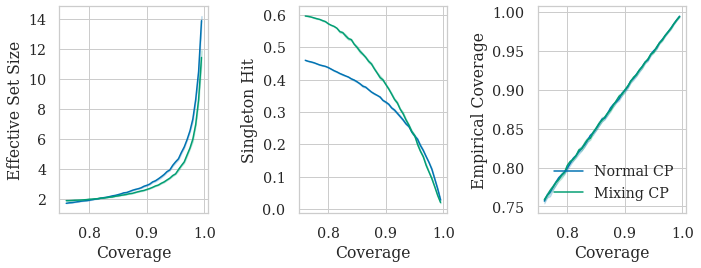

In [10]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)

f, axs = plt.subplots(1, 3, figsize=(10, 4))

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Normal CP", color="#0173B2")
sns.lineplot(data=mixing_cp_results, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Mixing CP", color="#029E73")

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Normal CP", color="#0173B2")
sns.lineplot(data=mixing_cp_results, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Mixing CP", color="#029E73")

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Normal CP", color="#0173B2")
sns.lineplot(data=mixing_cp_results, x="coverage_guarantee", y="empi_coverage", ax=axs[2],label="Mixing CP", color="#029E73")

axs[0].set_xlabel("Coverage")
axs[0].set_ylabel("Effective Set Size")
axs[0].set_title("")

axs[1].set_xlabel("Coverage")
axs[1].set_ylabel("Singleton Hit")
axs[1].set_title("")

axs[2].set_xlabel("Coverage")
axs[2].set_ylabel("Empirical Coverage")
axs[2].set_title("")

axs[0].legend().remove()
axs[1].legend().remove()
axs[2].legend()

f.tight_layout()
plt.savefig(os.path.join(figures_dir, "ogbn-arxiv.pgf"), format="pgf", bbox_inches='tight')

In [11]:
def compute_tune_calib_fraction(instance):
    tune_fraction = np.round(instance["train_idx"].shape[0] / instance["test_idx"].shape[0], 3)
    calib_fraction = np.round(instance["train_idx"].shape[0] / (instance["test_idx"].shape[0] - instance["train_idx"].shape[0]), 3)
    return tune_fraction, calib_fraction

def tune_truetest_split(test_idx, dataset, tuning_fraction):
    te_idx, tu_idx, _, _ = dataset_manager.train_test_split(test_idx, dataset.y[test_idx], training_fraction=tuning_fraction)
    return te_idx, tu_idx

In [12]:
def fair_shuffle_test_multiple_metrics(
    scores, y_true_mask, coverage_guarantee=0.92,
    n_iters=10, 
    metrics_dict={"set_size": lambda pred_set, true_mask: GraphCP.average_set_size(pred_set),
                  "coverage": lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask),
                  "argmax_accuracy": lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)},
    calib_fraction=0.5, tune_scores=None, tune_mask=None):
    
    result_df = []
    for iter_idx in range(n_iters):
        iteration_series = pd.Series({"attempt": iter_idx})
        calib_scores_sub, eval_scores, calib_ymask_sub, eval_ymask = GraphDataManager.train_test_split(
            scores, y_true_mask, training_fraction=calib_fraction, return_idx=False)
        calib_scores = calib_scores_sub if tune_scores is None else torch.concat([calib_scores_sub, tune_scores])
        calib_ymask = calib_ymask_sub if tune_mask is None else torch.concat([calib_ymask_sub, tune_mask])
        scores_quantile = GraphCP(transformation_sequence=[], coverage_guarantee=coverage_guarantee).calibrate_from_scores(calib_scores, calib_ymask)
        pred_set = eval_scores > scores_quantile
        for metric_name, metric_func in metrics_dict.items():
            result_val = metric_func(pred_set, eval_ymask)
            iteration_series[metric_name] = result_val
        result_df.append(iteration_series)

    result_df = pd.DataFrame(result_df)
    return result_df

# preparing first ingrediant of CP
def compare_cps(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res


# preparing first ingrediant of CP
def compare_cps_fair(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, tune_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = fair_shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], 
                                                         coverage_guarantee=coverage_val,metrics_dict=metrics_dict, 
                                                         calib_fraction=calib_fraction, n_iters=n_iters, 
                                                         tune_scores=baseline_scores[tune_idx], tune_mask=label_mask[tune_idx])

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

In [13]:
selected_coverage=0.92
k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

def find_all_regular_params(softs, dataset, coverage_val, tune_idx, n_iterations=20):
    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 1.5])
    
    label_mask = F.one_hot(dataset.y).bool()
    
    iteration_results = []
    overal_regular_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=False).pipe_transform(softs)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_sets = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overal_regular_results = [{"k_reg": 0, "penalty": 0, "average_set_size": base_cp.average_set_size(baseline_pred_sets)}]
        for k_reg in k_regs:
            for penalty in penalties:
                regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
                cp = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(regular_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(regular_scores[tune_idx])
                # print(cp.average_set_size(pred_set))

                overal_regular_results.append({
                    "k_reg": k_reg, "penalty": penalty,
                    "average_set_size": cp.average_set_size(pred_set)
                })
        overal_regular_results = pd.DataFrame(overal_regular_results)
        baseline_res = overal_regular_results.loc[(overal_regular_results["k_reg"] == 0) & (overal_regular_results["penalty"] == 0)]["average_set_size"].values[0]
        overal_regular_results["enhancement"] = overal_regular_results["average_set_size"] - baseline_res
        iteration_results.append(overal_regular_results[["enhancement"]])
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overal_regular_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["k_reg"], best_param_sets["penalty"])
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["k_reg"], best_param_series["penalty"])
    return overal_regular_results, best_params

def find_all_mixing_params(softs, dataset, coverage_val, tune_idx, n_iterations=20):
    lambda_vals = np.arange(0.05, 1, 0.05).round(3)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=False).pipe_transform(softs)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"lambda": 0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for lambda_v in lambda_vals:
            mixing_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_v, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
            cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

            cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
            pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                # print(cp.average_set_size(pred_set))
            overall_mixing_results.append({
                "lambda": lambda_v,
                "average_set_size": cp.average_set_size(pred_set)
            })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["lambda"], )
    return overall_mixing_results, best_params


In [14]:
instance = {
    "train_idx": train_idx,
    "val_idx": val_idx,
    "test_idx": test_idx,
    "model": model,
}
format_adapted_dataset = torch_geometric.data.Data(x=dataset.x, y=dataset.y.squeeze(), edge_index=edge_index)
tune_fraction = np.round((instance["val_idx"].shape[0] * 1/3) / instance["test_idx"].shape[0], 3)

tune_idx, true_test_idx = tune_truetest_split(instance["test_idx"], format_adapted_dataset, tune_fraction)
calib_fraction = np.round((instance["val_idx"].shape[0] * 2/3) / test_idx.shape[0], 3)

In [15]:
overal_reg_result, best_reg_params = find_all_regular_params(all_logits, format_adapted_dataset, 0.85, tune_idx, n_iterations=20)
overal_mix_result, best_mix_params = find_all_mixing_params(all_logits, format_adapted_dataset, 0.85, tune_idx, n_iterations=20)

In [16]:
true_mask = F.one_hot(dataset.y.squeeze()).bool().cpu()
test_mask = true_mask[true_test_idx]

aps_scores = cp_t.APSTransformation(softmax=True).pipe_transform(all_logits)
raps_scores = cp_t.RegularizerPenalty(k_reg=best_reg_params[0], penalty=best_reg_params[1]).pipe_transform(aps_scores)
mixing_scores = cp_gt.VertexMPTransformation(
    neigh_coef=best_mix_params[0], edge_index=edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(aps_scores)

aps_overall_results = []
for coverage_v in coverage_values:
    aps_result = fair_shuffle_test_multiple_metrics(
        aps_scores[true_test_idx], true_mask[true_test_idx],
        coverage_guarantee=coverage_v, 
        metrics_dict=metrics_dict,
        calib_fraction=calib_fraction, tune_scores=aps_scores[tune_idx], tune_mask=true_mask[tune_idx], n_iters=10)
    aps_result["coverage_guarantee"] = coverage_v
    aps_overall_results.append(aps_result)
aps_result = pd.concat(aps_overall_results).reset_index().drop(columns="index")

In [17]:
raps_result = GraphCP([]).shuffle_metrics_over_coverage(
    raps_scores[true_test_idx], true_mask[true_test_idx], coverage_values, 
    metrics_dict=metrics_dict, calib_fraction=calib_fraction)

mixing_result = GraphCP([]).shuffle_metrics_over_coverage(
    mixing_scores[true_test_idx], true_mask[true_test_idx], coverage_values, 
    metrics_dict=metrics_dict, calib_fraction=calib_fraction)

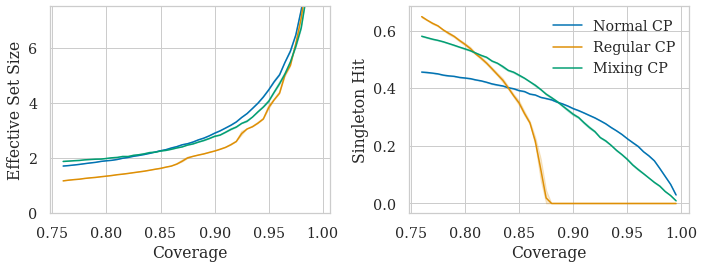

In [18]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)

f, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(data=aps_result, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Normal CP", color="#0173B2")
sns.lineplot(data=raps_result, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Regular CP", color="#DE8F05")
sns.lineplot(data=mixing_result, x="coverage_guarantee", y="average_set_size", ax=axs[0],label="Mixing CP", color="#029E73")

sns.lineplot(data=aps_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Normal CP", color="#0173B2")
sns.lineplot(data=raps_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Regular CP", color="#DE8F05")
sns.lineplot(data=mixing_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1],label="Mixing CP", color="#029E73")

axs[0].set_xlabel("Coverage")
axs[0].set_ylabel("Effective Set Size")
axs[0].set_title("")

axs[1].set_xlabel("Coverage")
axs[1].set_ylabel("Singleton Hit")
axs[1].set_title("")

axs[0].legend().remove()
axs[1].legend()

axs[0].set_ylim(0, 7.5)

f.tight_layout()
plt.savefig(os.path.join(figures_dir, "ogbn-arxiv-raps-comp.pgf"), format="pgf", bbox_inches='tight')